In [0]:
import keras
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten, Dense,BatchNormalization,Conv2D, MaxPool2D,AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [0]:
from google.colab import drive 
drive.mount('/mntDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /mntDrive


In [0]:
import numpy as np
images_train=np.load('/mntDrive/My Drive/Colab Notebooks/ml/image_train2.npy' )
labels_train=np.load('/mntDrive/My Drive/Colab Notebooks/ml/labels_train2.npy' )
valid_features=np.load('/mntDrive/My Drive/Colab Notebooks/ml/images_test2.npy' )
valid_labels=np.load('/mntDrive/My Drive/Colab Notebooks/ml/labels_test2.npy' )

data_directory = "/mntDrive/My Drive/Colab Notebooks/ml/"
image_labels = pd.read_csv(data_directory + 'label_name.csv').values

In [0]:
print(images_train.shape,labels_train.shape)

(7411, 96, 96, 3) (7411, 5)


In [0]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(images_train, labels_train, test_size=0.20, random_state=1)
print("-----TRAIN FEATURES-----")
print(train_features.shape)

print("-----VALID FEATURES-----")
print(valid_features.shape)

print("------TEST FEATURES-----")
print(test_features.shape)

-----TRAIN FEATURES-----
(5928, 96, 96, 3)
-----VALID FEATURES-----
(1536, 96, 96, 3)
------TEST FEATURES-----
(1483, 96, 96, 3)


In [0]:
train_features = train_features / 255
valid_features = valid_features / 255
test_features  = test_features  / 255

In [0]:
d1, d2, d3, d4 = train_features.shape
X = train_features.reshape((d1, d2*d3,d4))
r, g, b    = X[:, :, 0], X[:, :, 1], X[:, :, 2]

In [0]:
d1_2, d2_2, d3_2, d4_2 = valid_features.shape
X = valid_features.reshape((d1_2, d2_2*d3_2,d4_2))
r2, g2, b2    = X[:, :, 0], X[:, :, 1], X[:, :, 2]

In [0]:
# After mean normalization, covariance matrix is taken to convert it to input of svd.
from numpy.linalg import svd
def pca_manual(X):
  N = len(X)
  X = X - X.mean(axis=0) # Mean normalization
  # Covariance Matrix Process
  X = X.T
  Y = X.dot(X.T)/N
  U,S,V = svd(Y) # svd turns u,s,v values of array.
  print("Completed")
  return U,S,V

In [0]:
# U,S,V values are taken for all color channels.
u1,s1,v1 = pca_manual(r)
u2,s2,v2 = pca_manual(g)
u3,s3,v3 = pca_manual(b)


Completed
Completed
Completed


In [0]:
u1_1,s1_1,v1_1 = pca_manual(r2)
u2_1,s2_1,v2_1 = pca_manual(g2)
u3_1,s3_1,v3_1 = pca_manual(b2)

Completed
Completed
Completed


In [0]:
# The methods reconstructs given image by using 1,50,250,500,4096 components and displays them.
def reconstruct(u1,u2,u3,r,g,b,d1,d2,d3,d4):
  # The loop reconstruct and display images.
  i = 3000
  reconstructed_r_flatten = (r.dot(u1[:,0:i+1])).dot(u1[:,0:i+1].T) #Reconstruction of r channel with given cumulative U value like u1[:,0:10]
  reconstructed_g_flatten = (g.dot(u2[:,0:i+1])).dot(u2[:,0:i+1].T) #Reconstruction of g channel
  reconstructed_b_flatten = (b.dot(u3[:,0:i+1])).dot(u3[:,0:i+1].T) #Reconstruction of b channel
  # Combined to r,g,b values
  new_image = np.ones((d1,d2*d3,d4),'uint8')
  print(new_image.shape,reconstructed_r_flatten.shape)
  new_image[:,:,0], new_image[:,:,1], new_image[:,:,2] = reconstructed_r_flatten, reconstructed_g_flatten, reconstructed_b_flatten
  new_image = new_image.reshape((d1,d2,d3,d4))
  return new_image

In [0]:
train_features = reconstruct(u1,u2,u3,r,g,b,d1,d2,d3,d4)
#valid_features = reconstruct(u1_1,u2_1,u3_1,r2,g2,b2,d1_2,d2_2,d3_2,d4_2)

(5928, 9216, 3) (5928, 9216)
(1536, 9216, 3) (1536, 9216)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2,
                    shear_range=0.1,
                    rotation_range=10)
 
data_generator.fit(train_features)

In [0]:
def create_lenet_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape = images_train[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(5, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
def create_LeNet_model():
  model = keras.Sequential()

  #model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(96,96,3)))
  



  model.add(Flatten())



  model.add(Dense(5, activation='softmax'))
    
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
model = create_LeNet_model()
#from resnet import ResnetBuilder
from keras import backend as K
#K.set_image_dim_ordering('tf')
#model = ResnetBuilder.build_resnet_18((3,96,96), 5)
#model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
flatten_6 (Flatten)          (None, 141376)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 706885    
Total params: 707,333
Trainable params: 707,333
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit_generator(data_generator.flow(train_features, train_labels, batch_size = 50), 
                            validation_data=(valid_features, valid_labels), 
                            epochs=10, steps_per_epoch=2000, shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 196s 98ms/step - loss: 1.5188 - acc: 0.3611 - val_loss: 1.5257 - val_acc: 0.3906
Epoch 2/10
2000/2000 [==============================] - 195s 98ms/step - loss: 1.4317 - acc: 0.3919 - val_loss: 1.5648 - val_acc: 0.3665
Epoch 3/10
2000/2000 [==============================] - 196s 98ms/step - loss: 1.4102 - acc: 0.4041 - val_loss: 1.6284 - val_acc: 0.3626
Epoch 4/10
2000/2000 [==============================] - 196s 98ms/step - loss: 1.3985 - acc: 0.4134 - val_loss: 1.5956 - val_acc: 0.3464
Epoch 5/10
2000/2000 [==============================] - 195s 98ms/step - loss: 1.3944 - acc: 0.4150 - val_loss: 1.6375 - val_acc: 0.3737
Epoch 6/10
2000/2000 [==============================] - 194s 97ms/step - loss: 1.3881 - acc: 0.4153 - val_loss: 1.6325 - val_acc: 0.3737
Epoch 7/10
2000/2000 [==============================] - 193s 97ms/step - loss: 1.3916 - acc: 0.4150 - val_loss: 1.6635 - val_acc: 0.3757
Epoch 8/10
2000/2000 [===================

In [0]:
score = model.evaluate(test_features, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.6630050709982298
Test accuracy: 0.3553607552861814


In [0]:
sample_test_size = 28
test_predictions = model.predict(test_features)
print(test_predictions)

[[0.09233772 0.10309513 0.03681742 0.34306464 0.42468506]
 [0.37574726 0.01285285 0.02639561 0.31431353 0.27069068]
 [0.2576117  0.26198497 0.01941493 0.4227945  0.0381939 ]
 ...
 [0.04279496 0.7117389  0.17411312 0.06268922 0.00866379]
 [0.17028776 0.0040308  0.047061   0.757046   0.02157453]
 [0.08612492 0.01724965 0.19890113 0.45402202 0.24370223]]


In [0]:
print(test_predictions.shape)
print(np.amax(test_predictions))
print(np.argmax(test_predictions, axis=1).shape)
test_predictions=np.argmax(test_predictions, axis=1)

(1483, 5)
0.9997402
(1483,)


In [0]:
test_labels2=test_labels.argmax(1)
arr = test_labels2 == test_predictions
print(np.sum(arr)/arr.shape[0])

0.35536075522589344


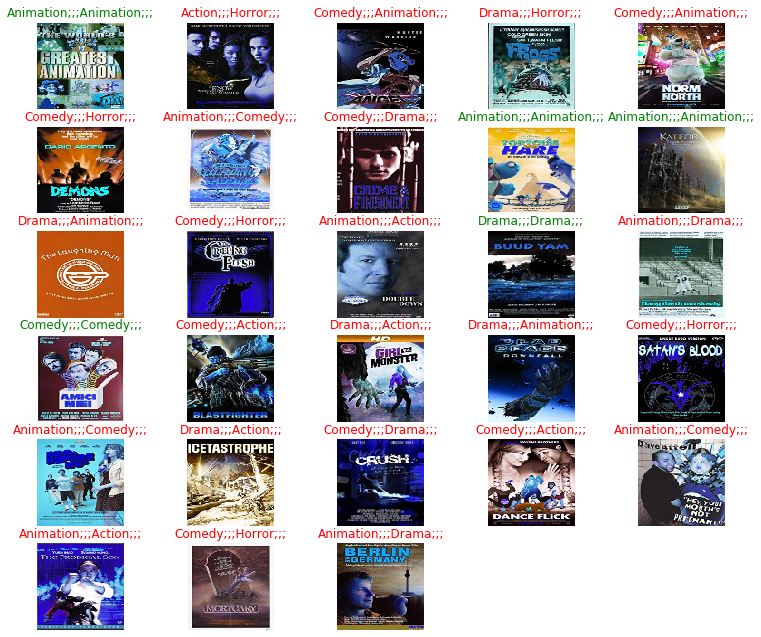

In [0]:
figure = plt.figure(figsize=(13,15))    
figure.tight_layout()

test_labels2=test_labels.argmax(1)
   
for index in range(sample_test_size):
    axes = figure.add_subplot(8, 5, index+1)
    label_prediction = image_labels[test_predictions[index]][1]
    
    label_actual = image_labels[test_labels2[index]][1]
    plt.imshow(test_features[index]) 
    plt.axis('off')

    if(label_prediction == label_actual):
        plt.title(label_prediction+label_actual, color="green")
    else:
        plt.title(label_prediction+label_actual, color="red")
    
plt.show()

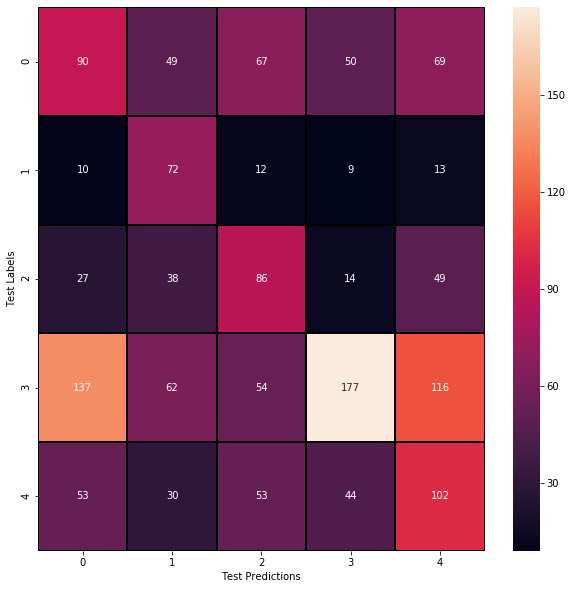

In [0]:
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_predictions, test_labels2)

f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, linewidths=1, linecolor='black', fmt='.0f', ax=ax)
plt.xlabel("Test Predictions")
plt.ylabel("Test Labels")
plt.show()

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from sklearn.metrics import classification_report
print(classification_report(test_predictions, test_labels2))

              precision    recall  f1-score   support

           0       0.28      0.28      0.28       325
           1       0.29      0.62      0.39       116
           2       0.32      0.40      0.35       214
           3       0.60      0.32      0.42       546
           4       0.29      0.36      0.32       282

    accuracy                           0.36      1483
   macro avg       0.36      0.40      0.35      1483
weighted avg       0.41      0.36      0.36      1483



In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    #if K.image_dim_ordering() == 'tf':
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    #else:
        #CHANNEL_AXIS = 1
        #ROW_AXIS = 2
        #COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        #if K.image_dim_ordering() == 'tf':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

Using TensorFlow backend.
